# Customer Segmentation of Lisbon Hotels Dataset

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, count, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

spark = SparkSession.builder.appName("HotelCustomerAnalysis").getOrCreate()

%matplotlib inline

24/04/22 10:40:56 WARN Utils: Your hostname, Gouris-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.191 instead (on interface en0)
24/04/22 10:40:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/22 10:40:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/22 10:40:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Initializing spark session & importing dataset

In [3]:
df = spark.read.csv('/Users/gouridumale/Downloads/HotelCustomersDataset.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- DaysSinceCreation: integer (nullable = true)
 |-- NameHash: string (nullable = true)
 |-- DocIDHash: string (nullable = true)
 |-- AverageLeadTime: integer (nullable = true)
 |-- LodgingRevenue: double (nullable = true)
 |-- OtherRevenue: double (nullable = true)
 |-- BookingsCanceled: integer (nullable = true)
 |-- BookingsNoShowed: integer (nullable = true)
 |-- BookingsCheckedIn: integer (nullable = true)
 |-- PersonsNights: integer (nullable = true)
 |-- RoomNights: integer (nullable = true)
 |-- DaysSinceLastStay: integer (nullable = true)
 |-- DaysSinceFirstStay: integer (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- SRHighFloor: integer (nullable = true)
 |-- SRLowFloor: integer (nullable = true)
 |-- SRAccessibleRoom: integer (nullable = true)
 |-- SRMediumFloor: integer (nullable = tru

In [4]:
df.show(5)

24/04/22 10:41:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-----------+----+-----------------+--------------------+--------------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+--------------------+--------------------+-----------+----------+----------------+-------------+---------+--------+------+-------------+---------+--------------+------------------+--------------------+-----------+
| ID|Nationality| Age|DaysSinceCreation|            NameHash|           DocIDHash|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay| DistributionChannel|       MarketSegment|SRHighFloor|SRLowFloor|SRAccessibleRoom|SRMediumFloor|SRBathtub|SRShower|SRCrib|SRKingSizeBed|SRTwinBed|SRNearElevator|SRAwayFromElevator|SRNoAlcoholInMiniBar|SRQuietRoom|
+---+-----------+----+-----------------+--------------------+--------------------+----------

## Exploratory Data Analysis

In [5]:
# Casting 'Age' as Integer
df = df.withColumn("Age", df["Age"].cast("integer"))

In [6]:
# Remove unwanted columns
df = df.drop(*["NameHash", "DocIDHash"])

In [7]:
# Rename columns as desired
df = df.withColumnRenamed("SRHighFloor", "HighFloor") \
            .withColumnRenamed("SRLowFloor", "LowFloor") \
            .withColumnRenamed("SRMediumFloor", "MediumFloor") \
            .withColumnRenamed("SRAccessibleRoom", "AccessibleRoom") \
            .withColumnRenamed("SRQuietRoom", "QuietRoom") \
            .withColumnRenamed("SRBathtub", "Bathtub") \
            .withColumnRenamed("SRShower", "Shower") \
            .withColumnRenamed("SRCrib", "Crib") \
            .withColumnRenamed("SRKingSizeBed", "KingBed") \
            .withColumnRenamed("SRTwinBed", "TwinBed") \
            .withColumnRenamed("SRNearElevator", "ElevatorNear") \
            .withColumnRenamed("SRAwayFromElevator", "ElevatorAway") \
            .withColumnRenamed("SRNoAlcoholInMiniBar", "NoAlcohol")

### Describe statistics of the dataframe

In [8]:
df.describe().show()

+-------+------------------+-----------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|summary|                ID|Nationality|               Age| DaysSinceCreation|  AverageLeadTime|   LodgingRevenue|      OtherRevenue|    BookingsCanceled|    BookingsNoShowed| BookingsCheckedIn|    PersonsNights|        RoomNights|DaysSinceLastStay|DaysSinceFirstStay| DistributionChannel|       MarketSegment|          HighFloor|            LowFloor|      AccessibleRoom|         MediumFloor|             Bathtub|      

### Check for missing values

In [9]:
from pyspark.sql.functions import count, when, col

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+---+-----------+----+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+
| ID|Nationality| Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay|DistributionChannel|MarketSegment|HighFloor|LowFloor|AccessibleRoom|MediumFloor|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|QuietRoom|
+---+-----------+----+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+-----------+

#### Impute missing value in 'Age' with its mean

In [10]:
from pyspark.sql.functions import mean

# Calculate the mean age (excluding null values)
mean_age = df.select(mean('Age')).collect()[0][0]

# Fill null values in the 'Age' column with the mean age
df = df.fillna(mean_age, subset=['Age'])


### Unique values in each column

In [11]:
from pyspark.sql.functions import col

unique_counts = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns))
unique_counts.show()

+-----+-----------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+
|   ID|Nationality|Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay|DistributionChannel|MarketSegment|HighFloor|LowFloor|AccessibleRoom|MediumFloor|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|QuietRoom|
+-----+-----------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+-------------------+-------------+---------+--------+--------------+---------

### Data Distribution

Visualize the distribution of numerical variables such as Age, AverageLeadTime, LodgingRevenue, and OtherRevenue using histograms or kernel density plots.

Explore the distribution of categorical variables like Nationality, DistributionChannel, MarketSegment using bar plots to understand the frequency of different categories.

## Numerical variables

### Age and AverageLeadTime

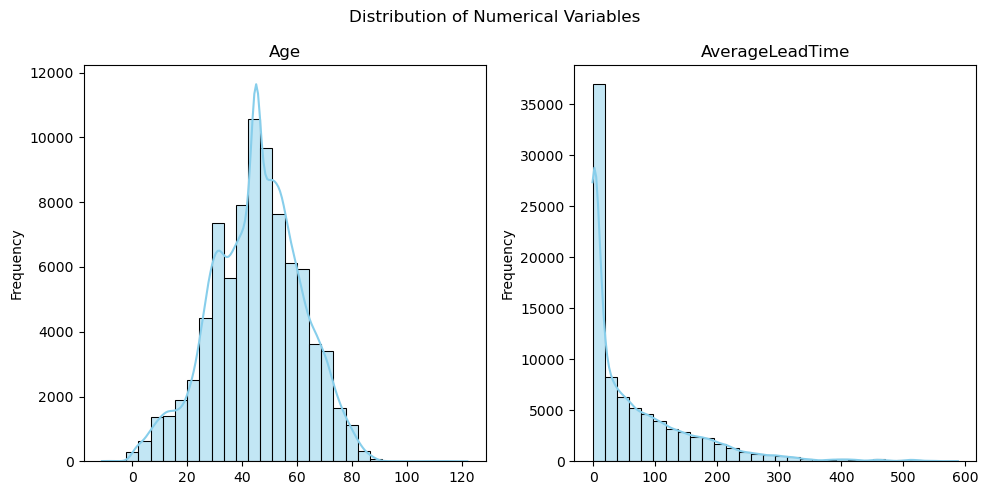

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten() # flatten the axes array to make it easier to iterate over

for i, col in enumerate(['Age','AverageLeadTime']):
    sns.histplot(df.select(col).toPandas()[col], bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Numerical Variables')
plt.tight_layout()
plt.show()

### Revenue (Lodging, Other)

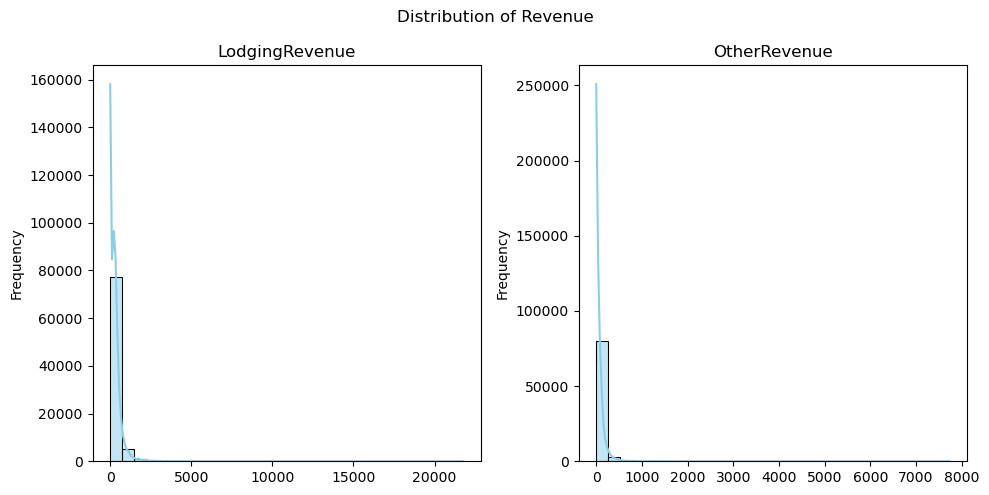

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten() # flatten the axes array to make it easier to iterate over

for i, col in enumerate(['LodgingRevenue', 'OtherRevenue']):
    sns.histplot(df.select(col).toPandas()[col], bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Revenue')
plt.tight_layout()
plt.show()

### Bookings (Cancelled, No show, Check ins)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the data for the booking-related variables
booking_data = df.select('BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn').toPandas()

# Function to remove outliers using IQR method
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Remove outliers from booking_data
booking_data_no_outliers = booking_data.apply(remove_outliers_iqr)

# Define colors for each dataset
colors = ['salmon', 'skyblue', 'lightgreen']

# Plot histograms for each booking-related variable after removing outliers
plt.figure(figsize=(14, 5))

for i, col in enumerate(booking_data_no_outliers.columns):
    plt.subplot(1, 3, i+1)
    counts, bins, _ = plt.hist(booking_data_no_outliers[col], bins=20, color=colors[i], edgecolor='black')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.ylabel('Frequency')

    # Add value of each bar on top of the bar
    for count, bin in zip(counts, bins):
        plt.text(bin, count, str(int(count)), ha='center', va='bottom')

plt.suptitle('Distribution of Bookings (After Removing Outliers)')
plt.tight_layout()
plt.show()


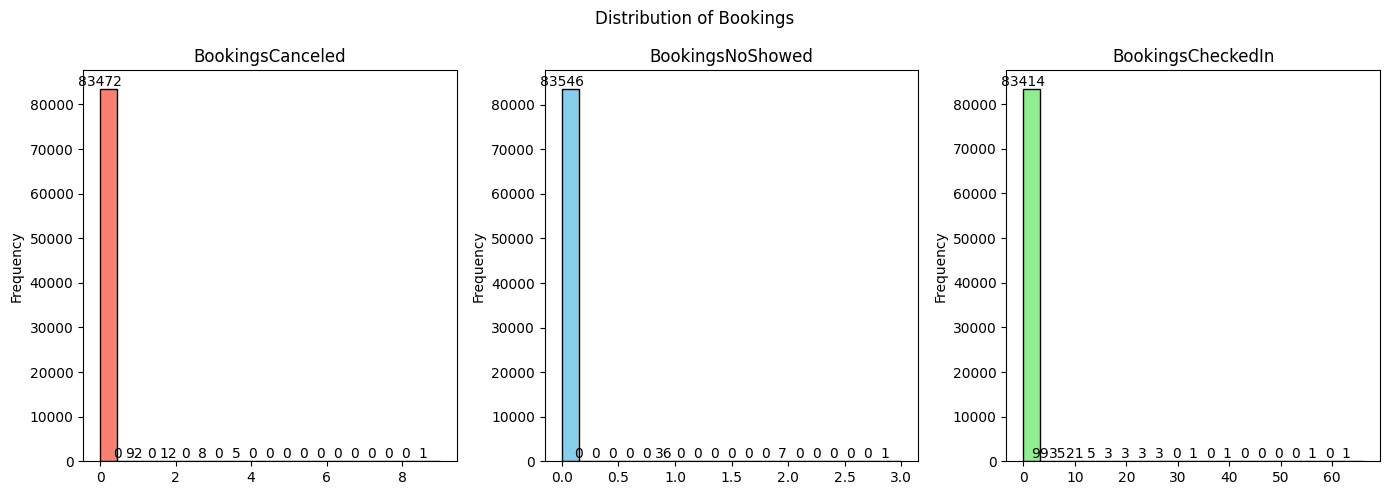

In [423]:
# Extract the data for the booking-related variables
booking_data = df.select('BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn').toPandas()

# Define colors for each dataset
colors = ['salmon', 'skyblue', 'lightgreen']

# Plot histograms_avg for each booking-related variable
plt.figure(figsize=(14, 5))

for i, col in enumerate(booking_data.columns):
    plt.subplot(1, 3, i+1)
    counts, bins, _ = plt.hist(booking_data[col], bins=20, color=colors[i], edgecolor='black')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.ylabel('Frequency')

    # Add value of each bar on top of the bar
    for count, bin in zip(counts, bins):
        plt.text(bin, count, str(int(count)), ha='center', va='bottom')

plt.suptitle('Distribution of Bookings')
plt.tight_layout()
plt.show()

### Nights (Persons, Rooms)

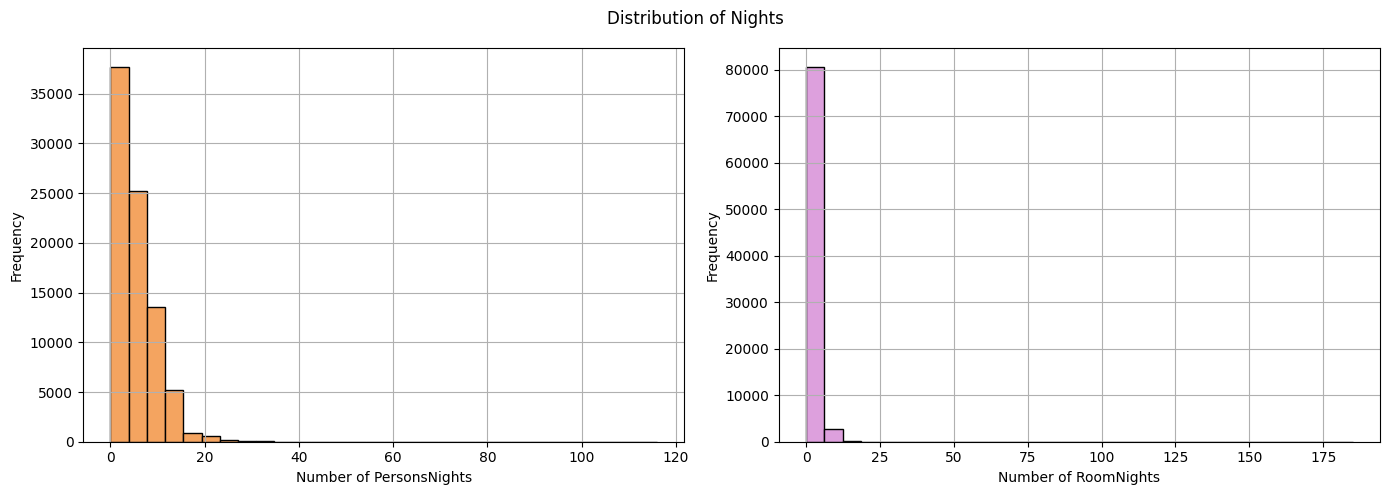

In [424]:
# Define the data for PersonsNights and RoomNights
persons_nights = df.select('PersonsNights').toPandas()
room_nights = df.select('RoomNights').toPandas()

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(14, 5))

# Plot histogram for PersonsNights
plt.subplot(1, 2, 1)
plt.hist(persons_nights['PersonsNights'], bins=30, color='sandybrown', edgecolor='black')
# plt.title('Distribution of PersonsNights')
plt.xlabel('Number of PersonsNights')
plt.ylabel('Frequency')
plt.grid(True)

# Plot histogram for RoomNights
plt.subplot(1, 2, 2)
plt.hist(room_nights['RoomNights'], bins=30, color='plum', edgecolor='black')
# plt.title('Distribution of RoomNights')
plt.xlabel('Number of RoomNights')
plt.ylabel('Frequency')
plt.grid(True)

# Adjust layout to prevent overlapping titles
plt.suptitle('Distribution of Nights')
plt.tight_layout()
plt.show()

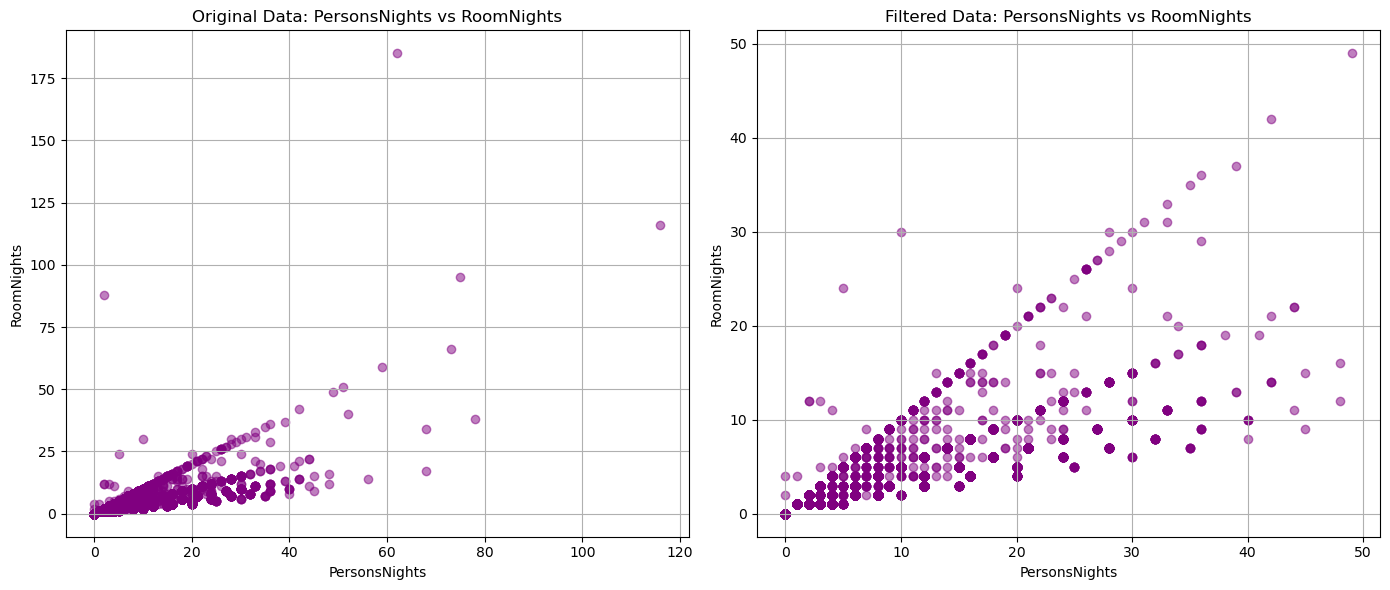

In [23]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Define the data for PersonsNights and RoomNights
persons_nights = df.select('PersonsNights').toPandas()
room_nights = df.select('RoomNights').toPandas()

# Create scatter plot for PersonsNights vs RoomNights (Original Data)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(persons_nights['PersonsNights'], room_nights['RoomNights'], color='purple', alpha=0.5)
plt.title('Original Data: PersonsNights vs RoomNights')
plt.xlabel('PersonsNights')
plt.ylabel('RoomNights')
plt.grid(True)

# Filter the data
dff = df.where(col("PersonsNights") < 50).where(col("RoomNights") < 50)
persons_nights_ = dff.select('PersonsNights').toPandas()
room_nights_ = dff.select('RoomNights').toPandas()

# Create scatter plot for PersonsNights vs RoomNights (Filtered Data)
plt.subplot(1, 2, 2)
plt.scatter(persons_nights_['PersonsNights'], room_nights_['RoomNights'], color='purple', alpha=0.5)
plt.title('Filtered Data: PersonsNights vs RoomNights')
plt.xlabel('PersonsNights')
plt.ylabel('RoomNights')
plt.grid(True)

plt.tight_layout()
plt.show()


### Correlation plot

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define numerical columns
numerical_columns = ['Age', 'DaysSinceCreation', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 
                     'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights', 'DaysSinceLastStay', 
                     'DaysSinceFirstStay']

# Calculate the correlation matrix
correlation_matrix = df.select(numerical_columns).toPandas().corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot for Numerical Variables')
plt.show()


## Boolean variables

Types of Floors (High, Middle, Lower) and Rooms (KingBed, Accessible, NoAlcohol, etc,)

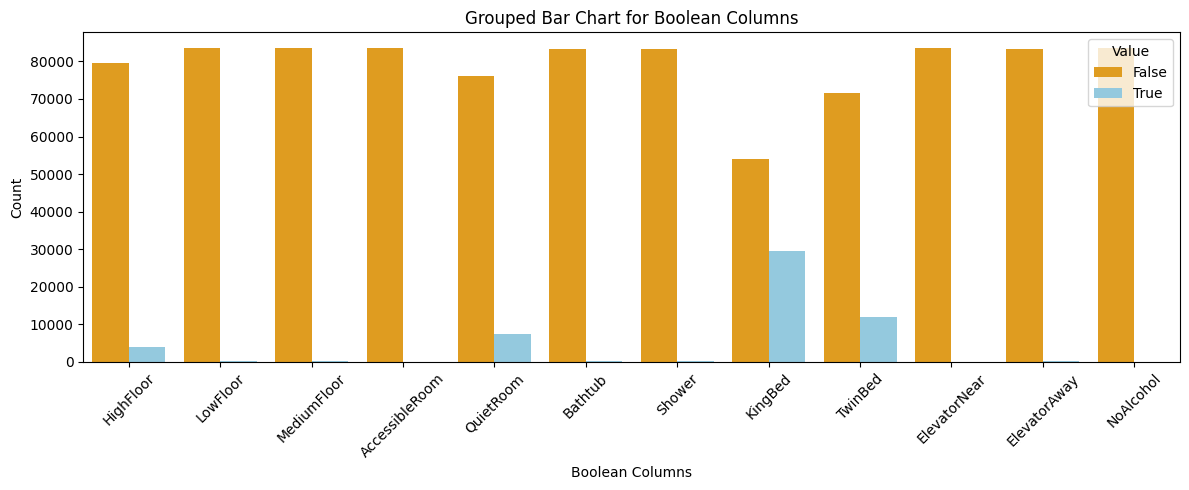

In [427]:
# Select boolean columns
bool_cols = ['HighFloor', 'LowFloor', 'MediumFloor', 'AccessibleRoom', 'QuietRoom', 
             'Bathtub', 'Shower', 'KingBed', 'TwinBed', 'ElevatorNear', 'ElevatorAway', 'NoAlcohol']
bool_df = df.select(bool_cols)

# Melt the DataFrame to long format
melted_df = bool_df.selectExpr("stack(12, 'HighFloor', HighFloor, 'LowFloor', LowFloor, \
                                    'MediumFloor', MediumFloor, 'AccessibleRoom', AccessibleRoom, \
                                    'QuietRoom', QuietRoom, 'Bathtub', Bathtub, 'Shower', Shower, \
                                    'KingBed', KingBed, 'TwinBed', TwinBed, 'ElevatorNear', ElevatorNear, \
                                    'ElevatorAway', ElevatorAway, 'NoAlcohol', NoAlcohol) \
                                    as (Boolean_Column, Value)")

# Plot
plt.figure(figsize=(12, 5))

# Plot grouped bar chart
sns.countplot(data=melted_df.toPandas(), x='Boolean_Column', hue='Value', palette={0: 'orange', 1: 'skyblue'})

# Add labels and title
plt.xlabel('Boolean Columns')
plt.ylabel('Count')
plt.title('Grouped Bar Chart for Boolean Columns')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.legend(title='Value', labels=['False', 'True'])
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Categorical variables

### Nationality

In [428]:
# Create a dictionary to map country names for abbreviations of available nationality:
country_codes = {
    "AFG": "Afghanistan",
    "ALB": "Albania",
    "DZA": "Algeria",
    "AND": "Andorra",
    "AGO": "Angola",
    "ATG": "Antigua and Barbuda",
    "ARG": "Argentina",
    "ARM": "Armenia",
    "AUS": "Australia",
    "AUT": "Austria",
    "AZE": "Azerbaijan",
    "BHS": "Bahamas",
    "BHR": "Bahrain",
    "BGD": "Bangladesh",
    "BRB": "Barbados",
    "BLR": "Belarus",
    "BEL": "Belgium",
    "BLZ": "Belize",
    "BEN": "Benin",
    "BTN": "Bhutan",
    "BOL": "Bolivia",
    "BIH": "Bosnia and Herzegovina",
    "BWA": "Botswana",
    "BRA": "Brazil",
    "BRN": "Brunei",
    "BGR": "Bulgaria",
    "BFA": "Burkina Faso",
    "BDI": "Burundi",
    "CPV": "Cabo Verde",
    "KHM": "Cambodia",
    "CMR": "Cameroon",
    "CAN": "Canada",
    "CAF": "Central African Republic",
    "TCD": "Chad",
    "CHL": "Chile",
    "CHN": "China",
    "COL": "Colombia",
    "COM": "Comoros",
    "CRI": "Costa Rica",
    "CIV": "Cote d'Ivoire",
    "HRV": "Croatia",
    "CUB": "Cuba",
    "CYP": "Cyprus",
    "CZE": "Czech Republic",
    "COD": "Democratic Republic of the Congo",
    "DNK": "Denmark",
    "DJI": "Djibouti",
    "DMA": "Dominica",
    "DOM": "Dominican Republic",
    "ECU": "Ecuador",
    "EGY": "Egypt",
    "SLV": "El Salvador",
    "GNQ": "Equatorial Guinea",
    "ERI": "Eritrea",
    "EST": "Estonia",
    "SWZ": "Eswatini",
    "ETH": "Ethiopia",
    "FJI": "Fiji",
    "FIN": "Finland",
    "FRA": "France",
    "GAB": "Gabon",
    "GMB": "Gambia",
    "GEO": "Georgia",
    "DEU": "Germany",
    "GHA": "Ghana",
    "GRC": "Greece",
    "GRD": "Grenada",
    "GTM": "Guatemala",
    "GIN": "Guinea",
    "GNB": "Guinea-Bissau",
    "GUY": "Guyana",
    "HTI": "Haiti",
    "HND": "Honduras",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IND": "India",
    "IDN": "Indonesia",
    "IRN": "Iran",
    "IRQ": "Iraq",
    "IRL": "Ireland",
    "ISR": "Israel",
    "ITA": "Italy",
    "JAM": "Jamaica",
    "JPN": "Japan",
    "JOR": "Jordan",
    "KAZ": "Kazakhstan",
    "KEN": "Kenya",
    "KIR": "Kiribati",
    "KWT": "Kuwait",
    "KGZ": "Kyrgyzstan",
    "LAO": "Laos",
    "LVA": "Latvia",
    "LBN": "Lebanon",
    "LSO": "Lesotho",
    "LBR": "Liberia",
    "LBY": "Libya",
    "LIE": "Liechtenstein",
    "LTU": "Lithuania",
    "LUX": "Luxembourg",
    "MDG": "Madagascar",
    "MWI": "Malawi",
    "MYS": "Malaysia",
    "MDV": "Maldives",
    "MLI": "Mali",
    "MLT": "Malta",
    "MHL": "Marshall Islands",
    "MRT": "Mauritania",
    "MUS": "Mauritius",
    "MEX": "Mexico",
    "FSM": "Micronesia",
    "MDA": "Moldova",
    "MCO": "Monaco",
    "MNG": "Mongolia",
    "MNE": "Montenegro",
    "MAR": "Morocco",
    "MOZ": "Mozambique",
    "MMR": "Myanmar",
    "NAM": "Namibia",
    "NRU": "Nauru",
    "NPL": "Nepal",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NIC": "Nicaragua",
    "NER": "Niger",
    "NGA": "Nigeria",
    "PRK": "North Korea",
    "MKD": "North Macedonia",
    "NOR": "Norway",
    "OMN": "Oman",
    "PAK": "Pakistan",
    "PLW": "Palau",
    "PAN": "Panama",
    "PNG": "Papua New Guinea",
    "PRY": "Paraguay",
    "PER": "Peru",
    "PHL": "Philippines",
    "POL": "Poland",
    "PRT": "Portugal",
    "QAT": "Qatar",
    "COG": "Republic of the Congo",
    "ROU": "Romania",
    "RUS": "Russia",
    "RWA": "Rwanda",
    "KNA": "Saint Kitts and Nevis",
    "LCA": "Saint Lucia",
    "VCT": "Saint Vincent and the Grenadines",
    "WSM": "Samoa",
    "SMR": "San Marino",
    "STP": "Sao Tome and Principe",
    "SAU": "Saudi Arabia",
    "SEN": "Senegal",
    "SRB": "Serbia",
    "SYC": "Seychelles",
    "SLE": "Sierra Leone",
    "SGP": "Singapore",
    "SVK": "Slovakia",
    "SVN": "Slovenia",
    "SLB": "Solomon Islands",
    "SOM": "Somalia",
    "ZAF": "South Africa",
    "KOR": "South Korea",
    "SSD": "South Sudan",
    "ESP": "Spain",
    "LKA": "Sri Lanka",
    "SDN": "Sudan",
    "SUR": "Suriname",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "SYR": "Syria",
    "TJK": "Tajikistan",
    "TZA": "Tanzania",
    "THA": "Thailand",
    "TLS": "Timor-Leste",
    "TGO": "Togo",
    "TON": "Tonga",
    "TTO": "Trinidad and Tobago",
    "TUN": "Tunisia",
    "TUR": "Turkey",
    "TKM": "Turkmenistan",
    "TUV": "Tuvalu",
    "TWN": "Taiwan",
    "UGA": "Uganda",
    "UKR": "Ukraine",
    "ARE": "United Arab Emirates",
    "GBR": "United Kingdom",
    "USA": "United States",
    "URY": "Uruguay",
    "UZB": "Uzbekistan",
    "VUT": "Vanuatu",
    "VAT": "Vatican City",
    "VEN": "Venezuela",
    "VNM": "Vietnam",
    "YEM": "Yemen",
    "ZMB": "Zambia",
    "ZWE": "Zimbabwe"
}

In [429]:
from pyspark.sql.functions import udf

# Define UDF to map country codes to country names
@udf(StringType())
def map_country_code(country_code):
    return country_codes.get(country_code, "Unknown")

# Map country codes to country names using UDF
df = df.withColumn("Country", map_country_code(df["Nationality"]))

# Get current columns except the one to be moved
other_columns = [col for col in df.columns if col != "Country"]

# Reorder columns
new_columns = other_columns[:2] + ["Country"] + other_columns[2:]

df = df.select(new_columns)

df.show(5)

+---+-----------+--------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+--------------------+--------------------+---------+--------+--------------+-----------+-------+------+----+-------+-------+------------+------------+---------+---------+
| ID|Nationality| Country|Age|DaysSinceCreation|AverageLeadTime|LodgingRevenue|OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|DaysSinceLastStay|DaysSinceFirstStay| DistributionChannel|       MarketSegment|HighFloor|LowFloor|AccessibleRoom|MediumFloor|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|QuietRoom|
+---+-----------+--------+---+-----------------+---------------+--------------+------------+----------------+----------------+-----------------+-------------+----------+-----------------+------------------+--------------------+-------------------

In [430]:
from pyspark.sql.functions import col

unknown_countries = df.filter((col("Country") == "Unknown"))
unknown_countries.count()

unknown_countries.groupBy("Nationality").count().orderBy("count", ascending=False).show(10)
# Since the unknown countries have lesser counts they can be ignored

51

In [432]:
country = df.groupBy("Country").count().orderBy("count", ascending=False)
country.show(5)

+--------------+-----+
|       Country|count|
+--------------+-----+
|        France|12422|
|      Portugal|11597|
|       Germany|10232|
|United Kingdom| 8656|
|         Spain| 4902|
+--------------+-----+
only showing top 5 rows



In [433]:
pd_country = country.toPandas()
pd_country.set_index("Country", inplace=True)
pd_country.head()

count
Country              
France          12422
Portugal        11597
Germany         10232
United Kingdom   8656
Spain            4902

In [434]:
# Define the data for the chloropleth map
fig = go.Figure(go.Choropleth(
    locations=pd_country.index,  # Country names
    z=pd_country['count'],  # Data values
    locationmode='country names',
    colorscale='Reds',
    colorbar_title='Counts',
))

# Update layout
fig.update_layout(
    title_text='Customer distribution by Country',
    geo=dict(
        showcoastlines=True,  # Show country coastlines
    ),
    width=800,  # Set the width of the figure
    height=600,  # Set the height of the figure
)


# Show the map
fig.show()

### Market segment and Distribution channel

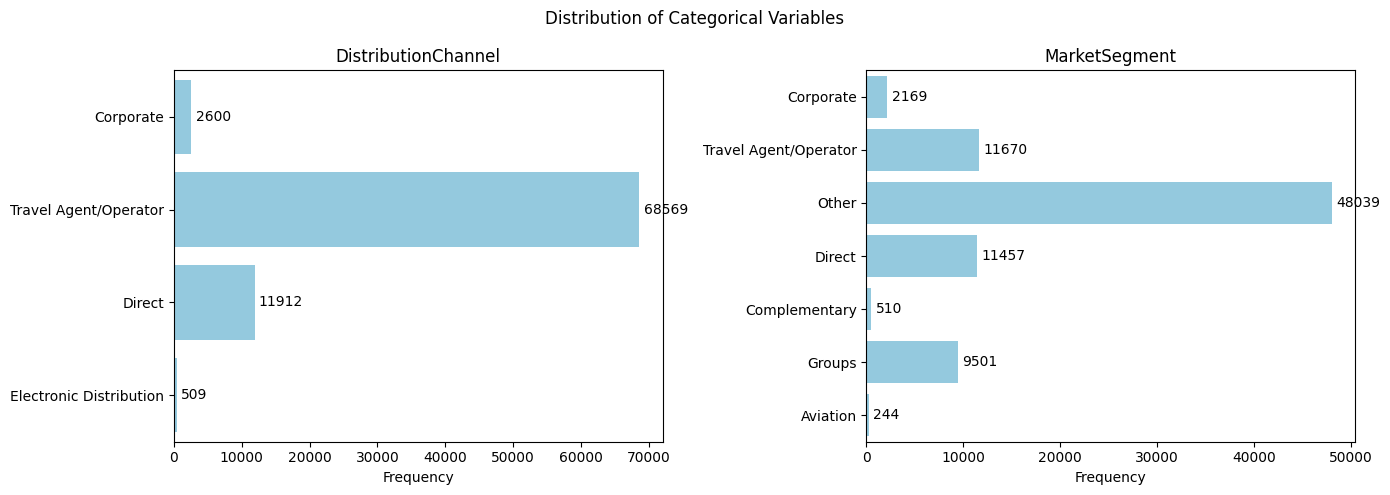

In [435]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(['DistributionChannel', 'MarketSegment']):
    sns.countplot(data=df.toPandas(), y=col, color='skyblue', ax=axes[i], legend=False)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x')  # Rotate x-axis labels for better readability

    for p in axes[i].patches:
        width = p.get_width()
        axes[i].annotate(f'{round(width)}', 
                         xy=(width, p.get_y() + p.get_height() / 2), 
                         xytext=(3, 0), 
                         textcoords='offset points', 
                         ha='left', 
                         va='center')
        
plt.suptitle('Distribution of Categorical Variables')
plt.tight_layout()
plt.show()

### Market Segment Analysis (average)

In [436]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn("MarketSegment", regexp_replace("MarketSegment", "Travel Agent/Operator", "Travel Agent"))

# Filter relevant columns for market segment analysis
ms_avg = df.select(['MarketSegment', 'Age', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'PersonsNights', 'RoomNights'])

# Aggregate data by market segment and calculate mean values for numeric variables
ms_avg = ms_avg.groupby('MarketSegment').mean()

# Rename columns using regular expression
from pyspark.sql.functions import regexp_replace

for column_name in ms_avg.columns:
    if column_name != "MarketSegment":
        ms_avg = ms_avg.withColumnRenamed(column_name, column_name.replace("avg(", "").replace(")", ""))

ms_avg.show()

+-------------+------------------+------------------+------------------+------------------+------------------+------------------+
|MarketSegment|               Age|   AverageLeadTime|    LodgingRevenue|      OtherRevenue|     PersonsNights|        RoomNights|
+-------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Complementary| 41.86470588235294| 19.99411764705882|22.810313725490197|16.794686274509807|3.2411764705882353|1.9627450980392156|
|     Aviation| 50.74180327868852| 5.864754098360656| 533.9850409836066| 80.84364754098361| 5.127049180327869| 4.991803278688525|
|        Other| 43.71575178500802| 59.68069693374134| 316.8261472969883| 66.74471325381457| 4.888798684402256|2.3256728907762443|
|       Direct|42.763899799249366|43.690494893951296| 316.7641031683689| 68.91962555642839| 4.318495243082832|2.0901632189927555|
| Travel Agent| 49.03384747215081| 99.86649528706084|  229.296255355613| 74.89342930591255

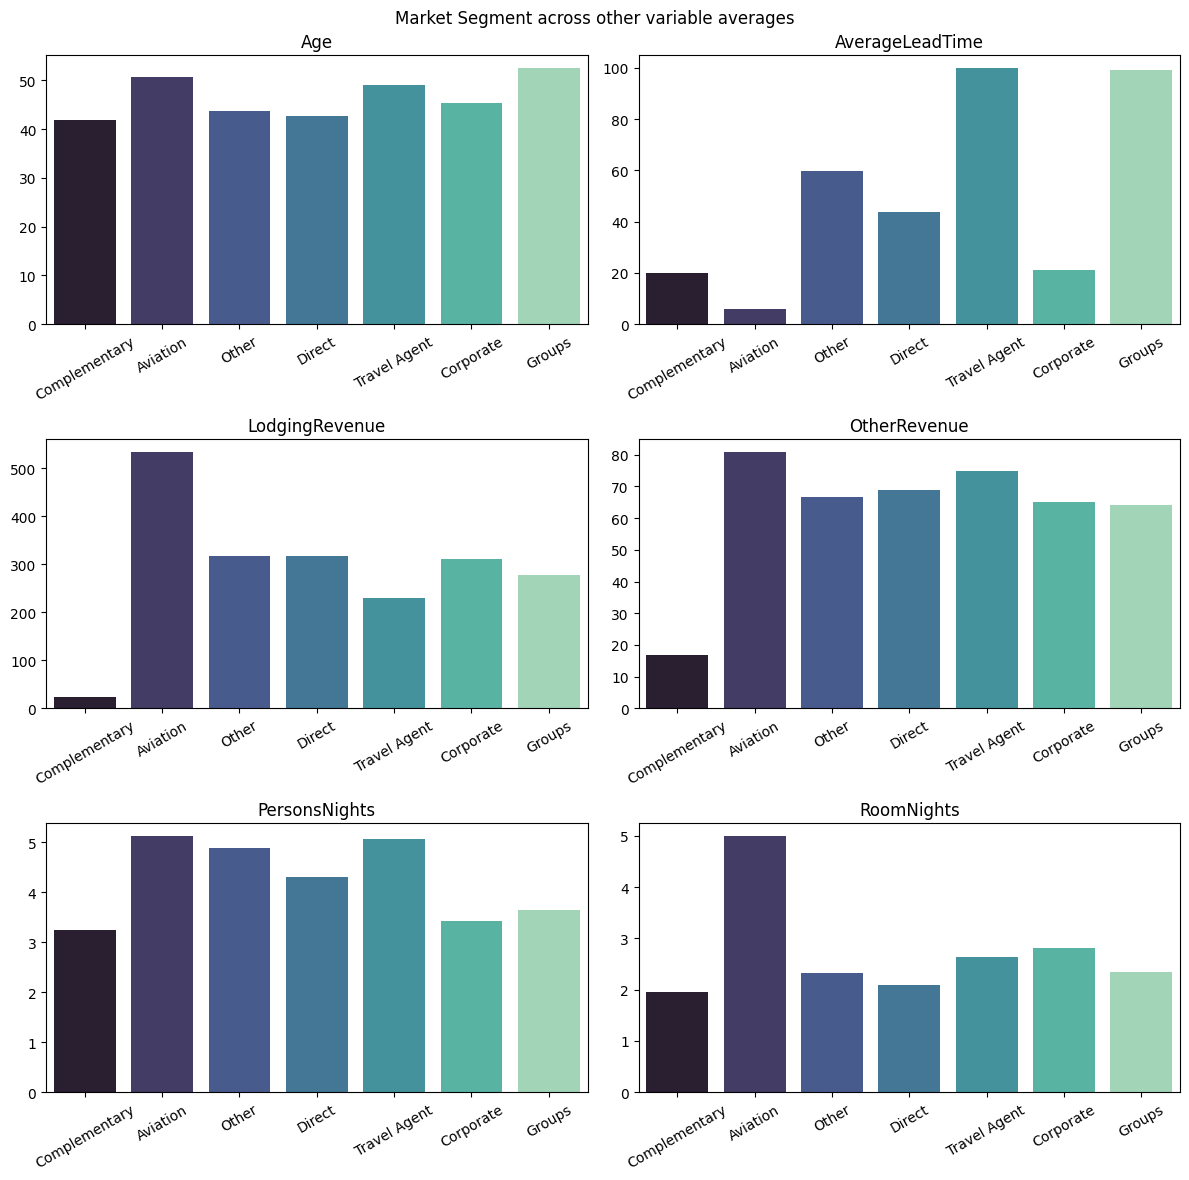

In [437]:
pd_ms_avg = ms_avg.toPandas()
pd_ms_avg.set_index("MarketSegment", inplace=True)

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Iterate over each column and plot
for i, x in enumerate(pd_ms_avg.columns):
    # Plot on the current subplot with default seaborn palette
    sns.barplot(x='MarketSegment', y=pd_ms_avg[x], data=pd_ms_avg, hue=pd_ms_avg.index, ax=axes[i], dodge=False, legend=False, palette = 'mako')
    
    # Rotate x-axis tick labels
    axes[i].tick_params(axis='x', rotation=30)
    
    # Add labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

plt.suptitle('Market Segment across other variable averages')
plt.tight_layout()
plt.show()


### Market Segment Analysis (Sum)

In [438]:
from pyspark.sql.functions import regexp_replace

# Filter relevant columns for market segment analysis
ms_sum = df.select(['MarketSegment', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights', 'HighFloor', 'LowFloor', 'MediumFloor', 'AccessibleRoom', 'QuietRoom', 'Bathtub', 'Shower', 'Crib', 'KingBed', 'TwinBed', 'ElevatorNear', 'ElevatorAway', 'NoAlcohol'])

# Aggregate data by market segment and calculate mean values for numeric variables
ms_sum = ms_sum.groupby('MarketSegment').sum()

# Rename columns using regular expression
from pyspark.sql.functions import regexp_replace

for column_name in ms_sum.columns:
    if column_name != "MarketSegment":
        ms_sum = ms_sum.withColumnRenamed(column_name, column_name.replace("sum(", "").replace(")", ""))

ms_sum.show()

+-------------+--------------------+------------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|MarketSegment|      LodgingRevenue|      OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|HighFloor|LowFloor|MediumFloor|AccessibleRoom|QuietRoom|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|
+-------------+--------------------+------------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|Complementary|            11633.26|           8565.29|              19|               0|              580|         1653|      1001|       13|       0|          1|             0|        2|      3|     0|  17|    166| 

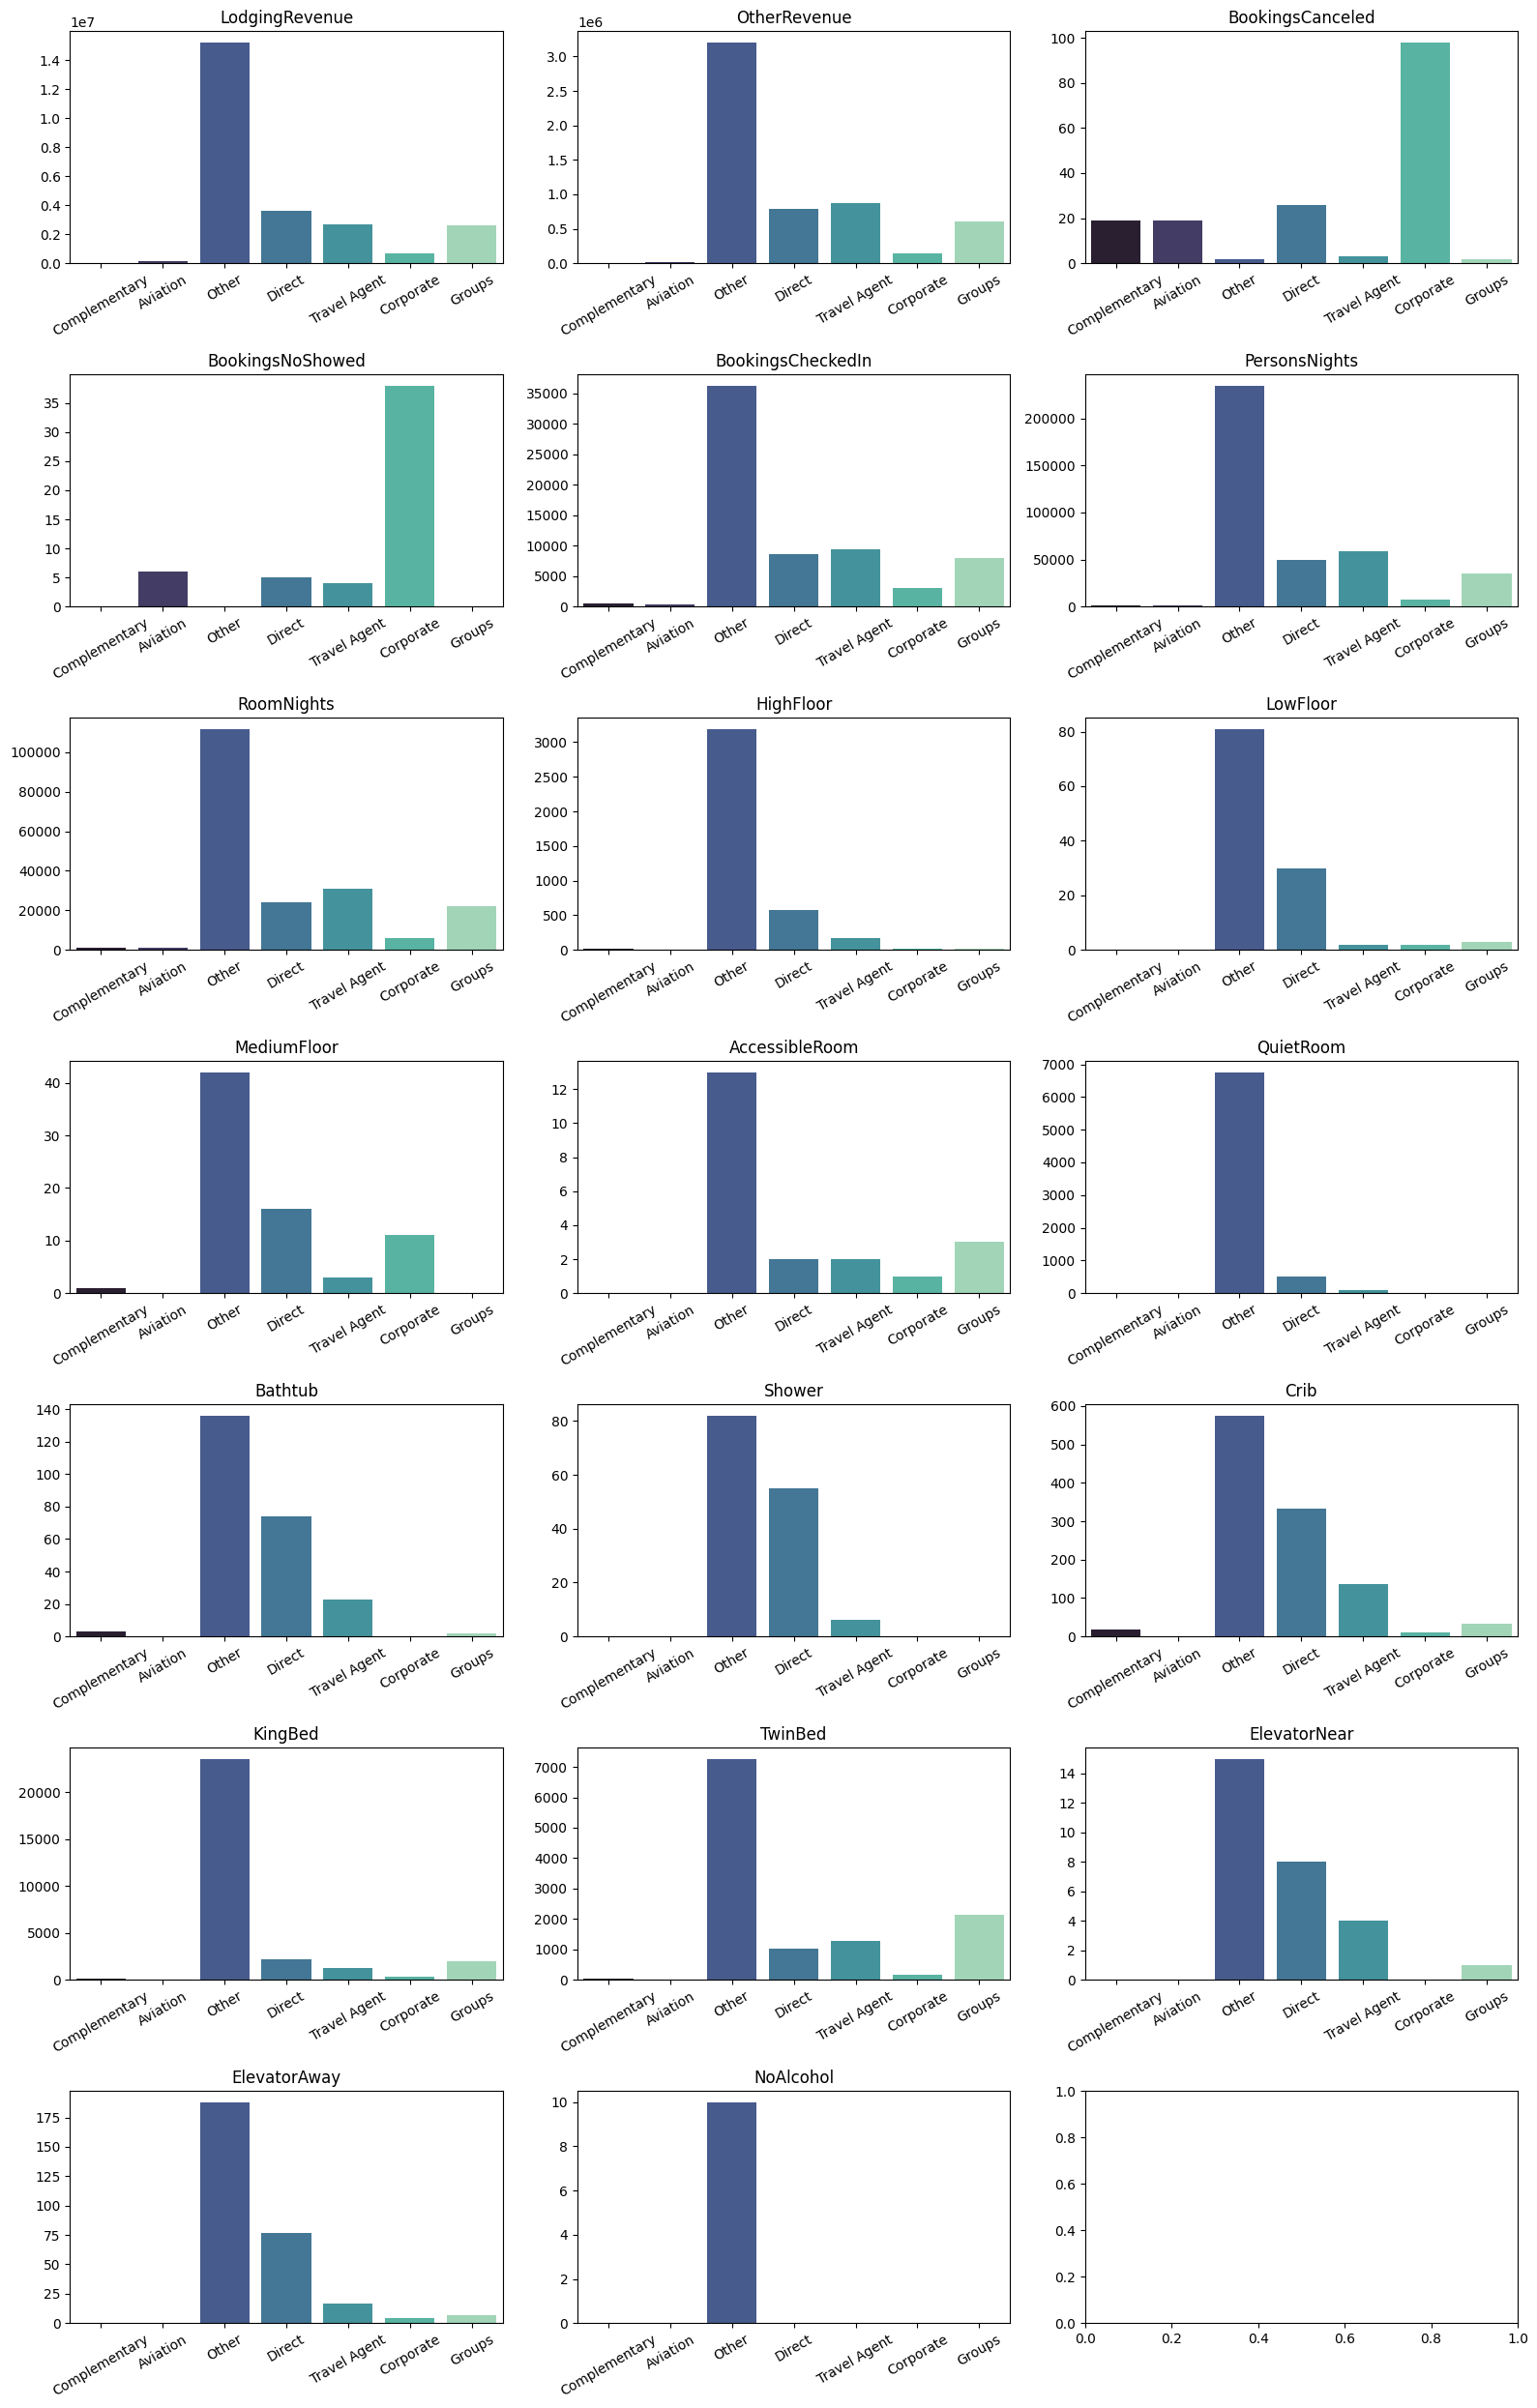

In [439]:
pd_ms_sum = ms_sum.toPandas()
pd_ms_sum.set_index("MarketSegment", inplace=True)

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(7, 3, figsize=(16, 25))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Iterate over each column and plot
for i, x in enumerate(pd_ms_sum.columns):
    # Plot on the current subplot with default seaborn palette
    sns.barplot(x='MarketSegment', y=pd_ms_sum[x], data=pd_ms_sum, hue=pd_ms_sum.index, ax=axes[i], dodge=False, legend=False, palette = 'mako')
    
    # Rotate x-axis tick labels
    axes[i].tick_params(axis='x', rotation=30)
    
    # Add labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

# plt.suptitle('Market Segment across other variables')
plt.tight_layout()
plt.show()


Inferences:-
 - Others generate the most revenue and check ins
 - Corporate has the most cancellations and no shows
 - Incidentally, since more people show up in the 'Others' category the corresponding bars in all the other charts are tallers 
- So let us try dropping the 'Others' category to visualize the trends within the remaining categories

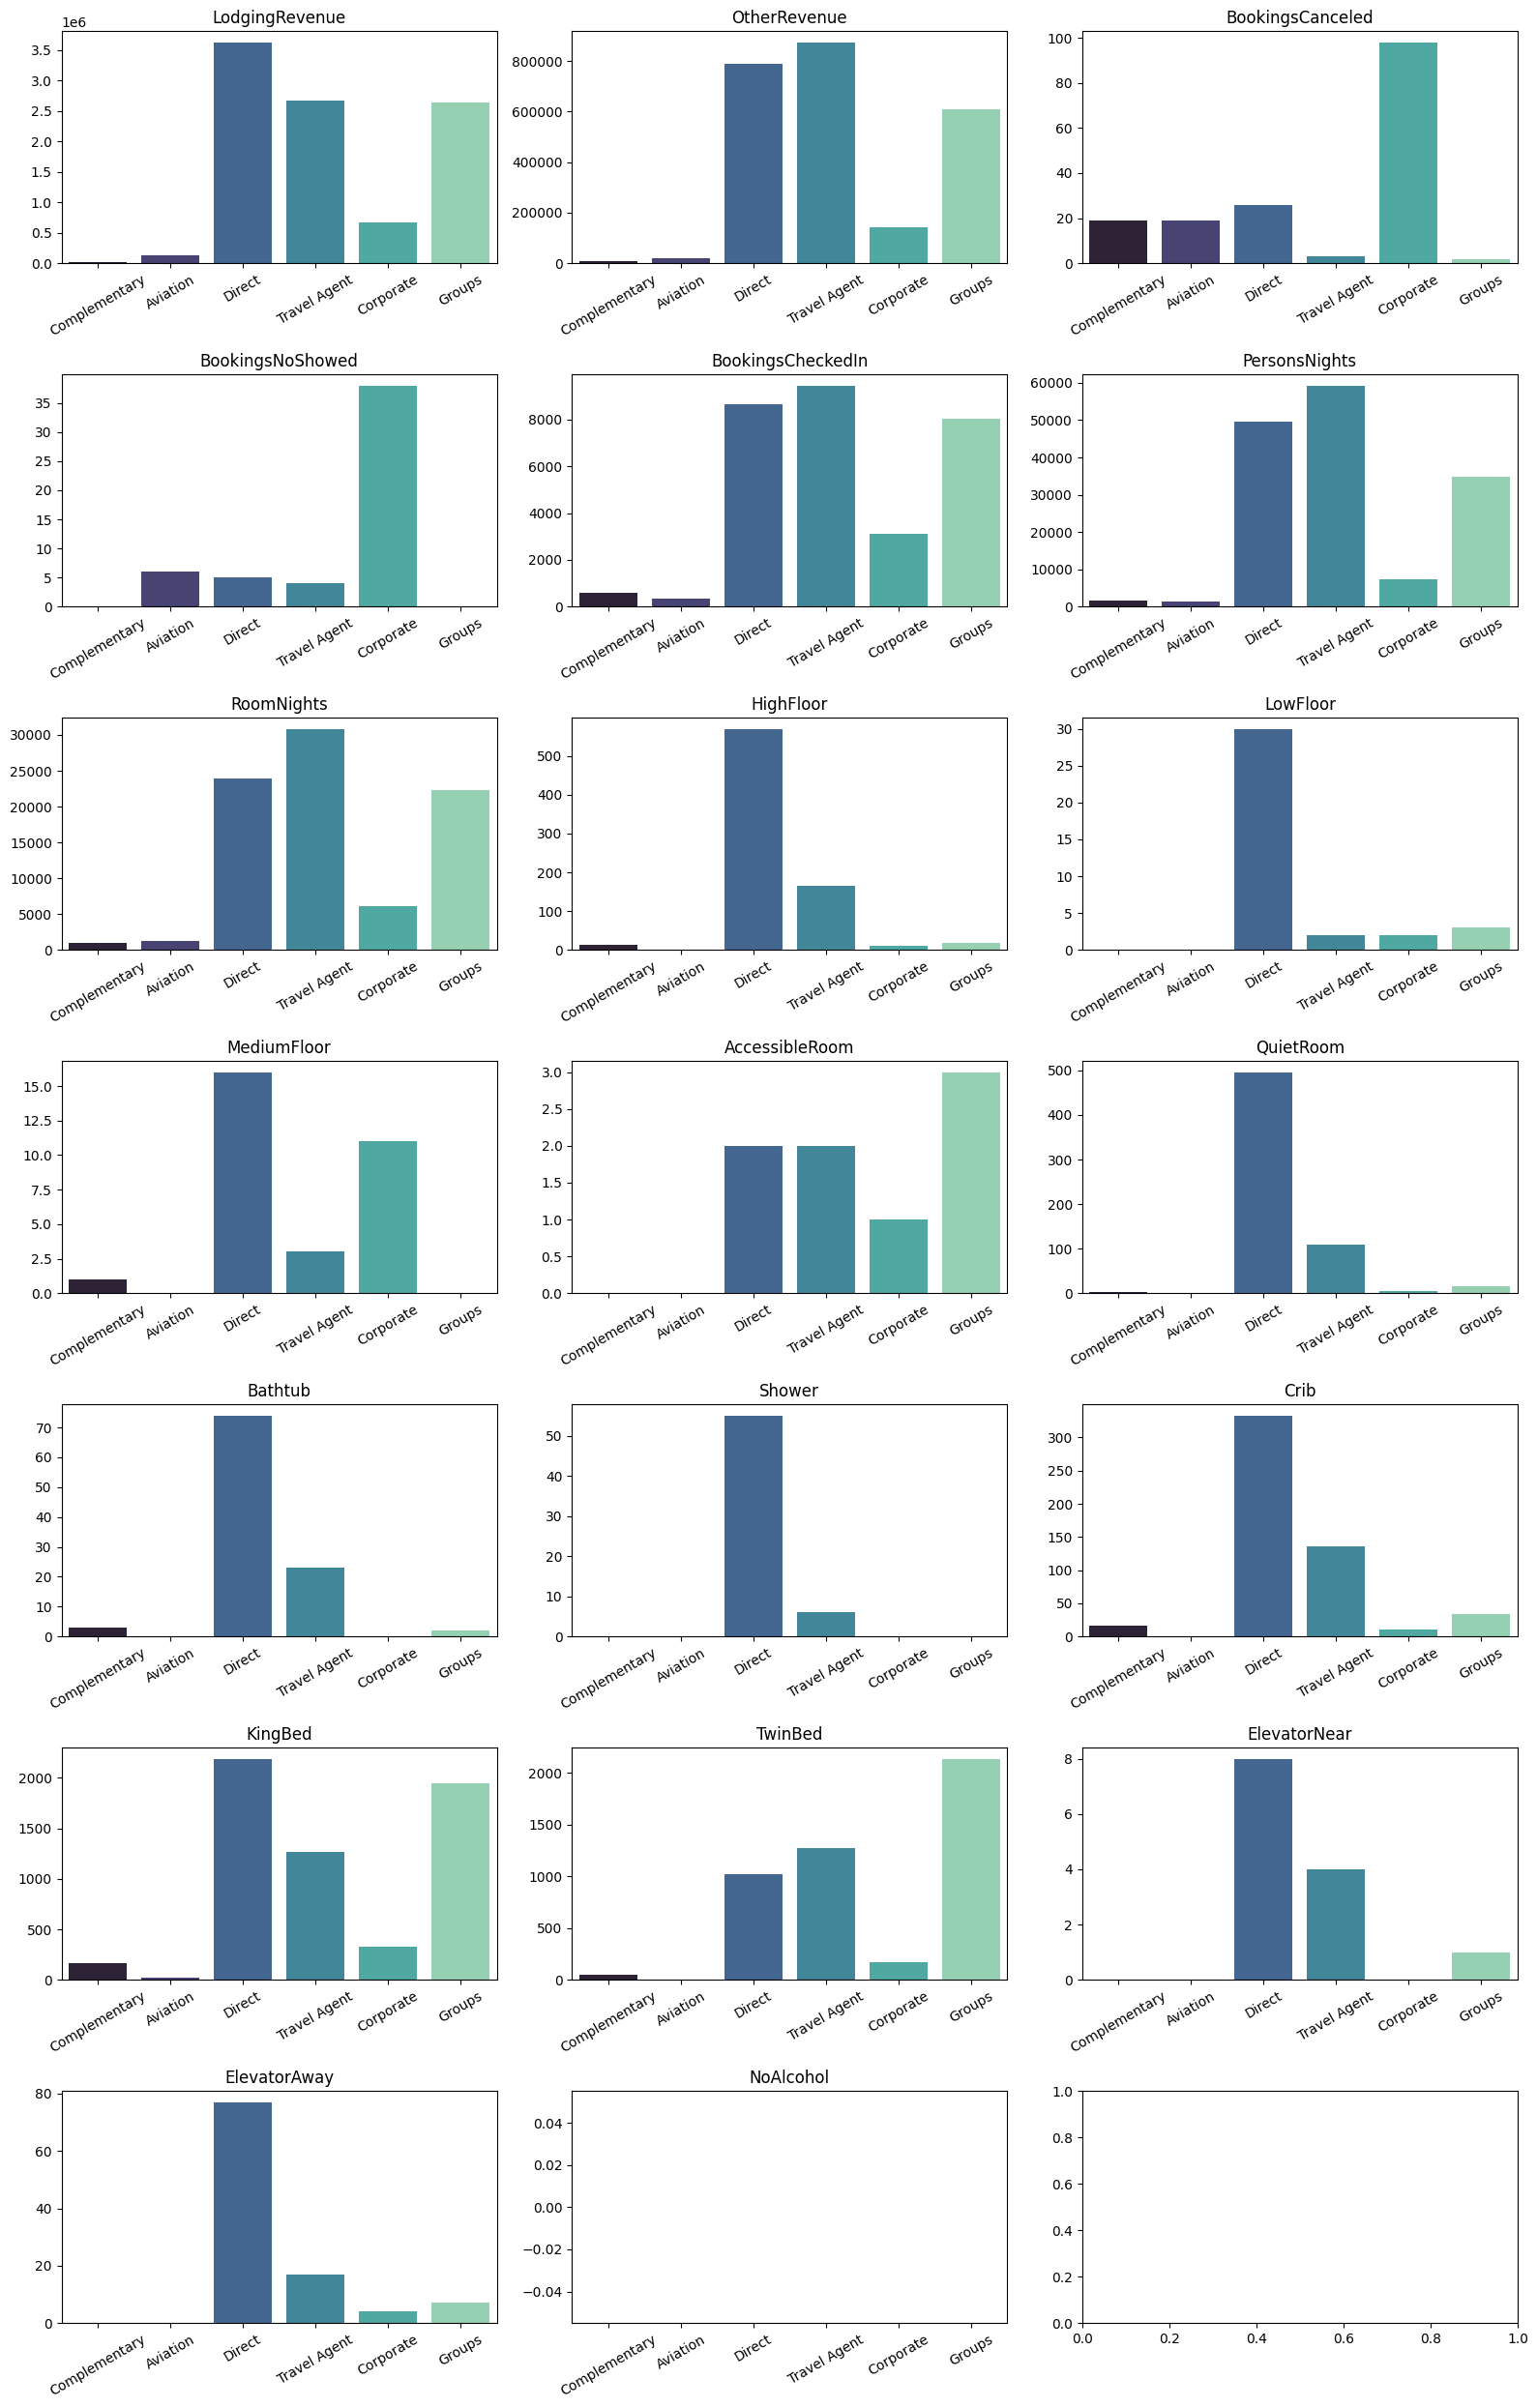

In [440]:
pd_ms_sum = pd_ms_sum.drop(index='Other')

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(7, 3, figsize=(16, 25))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Iterate over each column and plot
for i, x in enumerate(pd_ms_sum.columns):
    # Plot on the current subplot with default seaborn palette
    sns.barplot(x='MarketSegment', y=pd_ms_sum[x], data=pd_ms_sum, hue=pd_ms_sum.index, ax=axes[i], dodge=False, legend=False, palette = 'mako')
    
    # Rotate x-axis tick labels
    axes[i].tick_params(axis='x', rotation=30)
    
    # Add labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

# plt.suptitle('Market Segment across other variable sum')
plt.tight_layout()
plt.show()


Inferences:-
- Without the 'Others' category we can see that majority of the remaining revenue and check ins come from 'Direct', 'Groups' and 'Travel Agent'
- Incidentally, PersonsNights and RoomNights are higher for these categories
- Corporate tends to request 'Medium Floors' and 'Accessible Rooms' more
- 'Direct'  dominates almost all the floors and rooms except Twin beds
- 'Accesssible Rooms' are requested by almost all categories except 'Aviation'

### Distribution Channel Analysis (average)

In [441]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn("DistributionChannel", regexp_replace("DistributionChannel", "Travel Agent/Operator", "Travel Agent"))
df = df.withColumn("DistributionChannel", regexp_replace("DistributionChannel", "Electronic Distribution", "Electronic"))

In [442]:
# Filter relevant columns for market segment analysis
dc_avg = df.select(['DistributionChannel', 'Age', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'PersonsNights', 'RoomNights'])

# Aggregate data by market segment and calculate mean values for numeric variables
dc_avg = dc_avg.groupby('DistributionChannel').mean()
dc_avg.show()

+-------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+
|DistributionChannel|          avg(Age)|avg(AverageLeadTime)|avg(LodgingRevenue)|avg(OtherRevenue)|avg(PersonsNights)|   avg(RoomNights)|
+-------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+
|             Direct| 42.74479516453996|   42.72070181329752| 302.83532824042993|66.09035678307589|  4.25260241773002|2.0570852921423772|
|       Travel Agent|45.804868089078155|   71.90338199477898|  297.1549254036078|68.12681911651035| 4.776079569484753|2.3883095859645027|
|          Corporate|46.737307692307695|  32.003076923076925| 326.37633076923083|66.92672307692308| 3.568846153846154|3.0034615384615386|
|         Electronic| 42.88801571709234|  21.387033398821217| 285.45675834970535|33.61465618860511| 2.345776031434185|2.1080550098231825|
+-------------------+-------------

In [443]:
# Rename columns using regular expression

from pyspark.sql.functions import regexp_replace

for column_name in dc_avg.columns:
    if column_name != "DistributionChannel":
        dc_avg = dc_avg.withColumnRenamed(column_name, column_name.replace("avg(", "").replace(")", ""))

dc_avg.show()

+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|DistributionChannel|               Age|   AverageLeadTime|    LodgingRevenue|     OtherRevenue|    PersonsNights|        RoomNights|
+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|             Direct| 42.74479516453996| 42.72070181329752|302.83532824042993|66.09035678307589| 4.25260241773002|2.0570852921423772|
|       Travel Agent|45.804868089078155| 71.90338199477898| 297.1549254036078|68.12681911651035|4.776079569484753|2.3883095859645027|
|          Corporate|46.737307692307695|32.003076923076925|326.37633076923083|66.92672307692308|3.568846153846154|3.0034615384615386|
|         Electronic| 42.88801571709234|21.387033398821217|285.45675834970535|33.61465618860511|2.345776031434185|2.1080550098231825|
+-------------------+------------------+------------------+---

In [444]:
pd_dc_avg = dc_avg.toPandas()
pd_dc_avg.set_index("DistributionChannel", inplace=True)
pd_dc_avg.head()

Age  AverageLeadTime  LodgingRevenue  OtherRevenue  \
DistributionChannel                                                             
Direct               42.744795        42.720702      302.835328     66.090357   
Travel Agent         45.804868        71.903382      297.154925     68.126819   
Corporate            46.737308        32.003077      326.376331     66.926723   
Electronic           42.888016        21.387033      285.456758     33.614656   

                     PersonsNights  RoomNights  
DistributionChannel                             
Direct                    4.252602    2.057085  
Travel Agent              4.776080    2.388310  
Corporate                 3.568846    3.003462  
Electronic                2.345776    2.108055

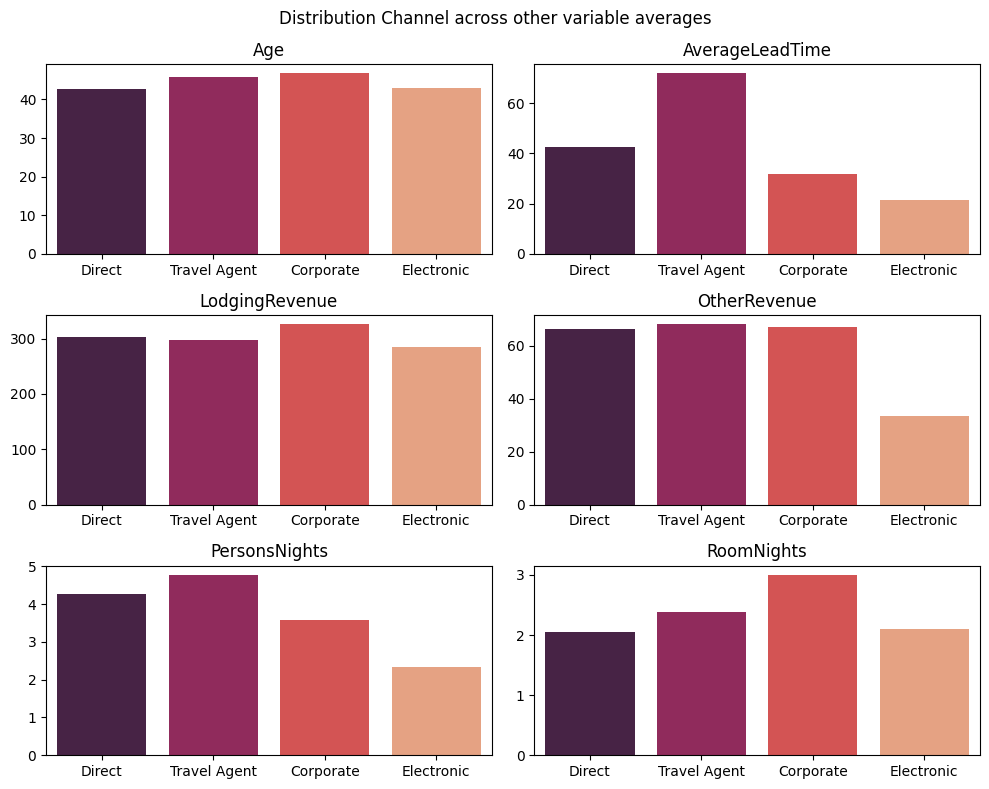

In [445]:
# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Iterate over each column and plot
for i, x in enumerate(pd_dc_avg.columns):
    # Plot on the current subplot with default seaborn palette
    sns.barplot(x='DistributionChannel', y=pd_dc_avg[x], data=pd_dc_avg, hue=pd_dc_avg.index, ax=axes[i], dodge=False, legend=False, palette = 'rocket')
    
    # Add labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

plt.suptitle('Distribution Channel across other variable averages')
plt.tight_layout()
plt.show()

### Distribution Channel Analysis (sum)

In [446]:
from pyspark.sql.functions import regexp_replace

# Filter relevant columns for market segment analysis
dc_sum = df.select(['DistributionChannel', 'LodgingRevenue', 'OtherRevenue', 'BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'PersonsNights', 'RoomNights', 'HighFloor', 'LowFloor', 'MediumFloor', 'AccessibleRoom', 'QuietRoom', 'Bathtub', 'Shower', 'Crib', 'KingBed', 'TwinBed', 'ElevatorNear', 'ElevatorAway', 'NoAlcohol'])

# Aggregate data by market segment and calculate mean values for numeric variables
dc_sum = dc_sum.groupby('DistributionChannel').sum()

# Rename columns using regular expression
from pyspark.sql.functions import regexp_replace

for column_name in dc_sum.columns:
    if column_name != "DistributionChannel":
        dc_sum = dc_sum.withColumnRenamed(column_name, column_name.replace("sum(", "").replace(")", ""))

dc_sum.show()

+-------------------+--------------------+------------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|DistributionChannel|      LodgingRevenue|      OtherRevenue|BookingsCanceled|BookingsNoShowed|BookingsCheckedIn|PersonsNights|RoomNights|HighFloor|LowFloor|MediumFloor|AccessibleRoom|QuietRoom|Bathtub|Shower|Crib|KingBed|TwinBed|ElevatorNear|ElevatorAway|NoAlcohol|
+-------------------+--------------------+------------------+----------------+----------------+-----------------+-------------+----------+---------+--------+-----------+--------------+---------+-------+------+----+-------+-------+------------+------------+---------+
|             Direct|  3607374.4300000016| 787268.3300000001|              40|               6|             9121|        50657|     24504|      575|      28|         13|             2|      502|     

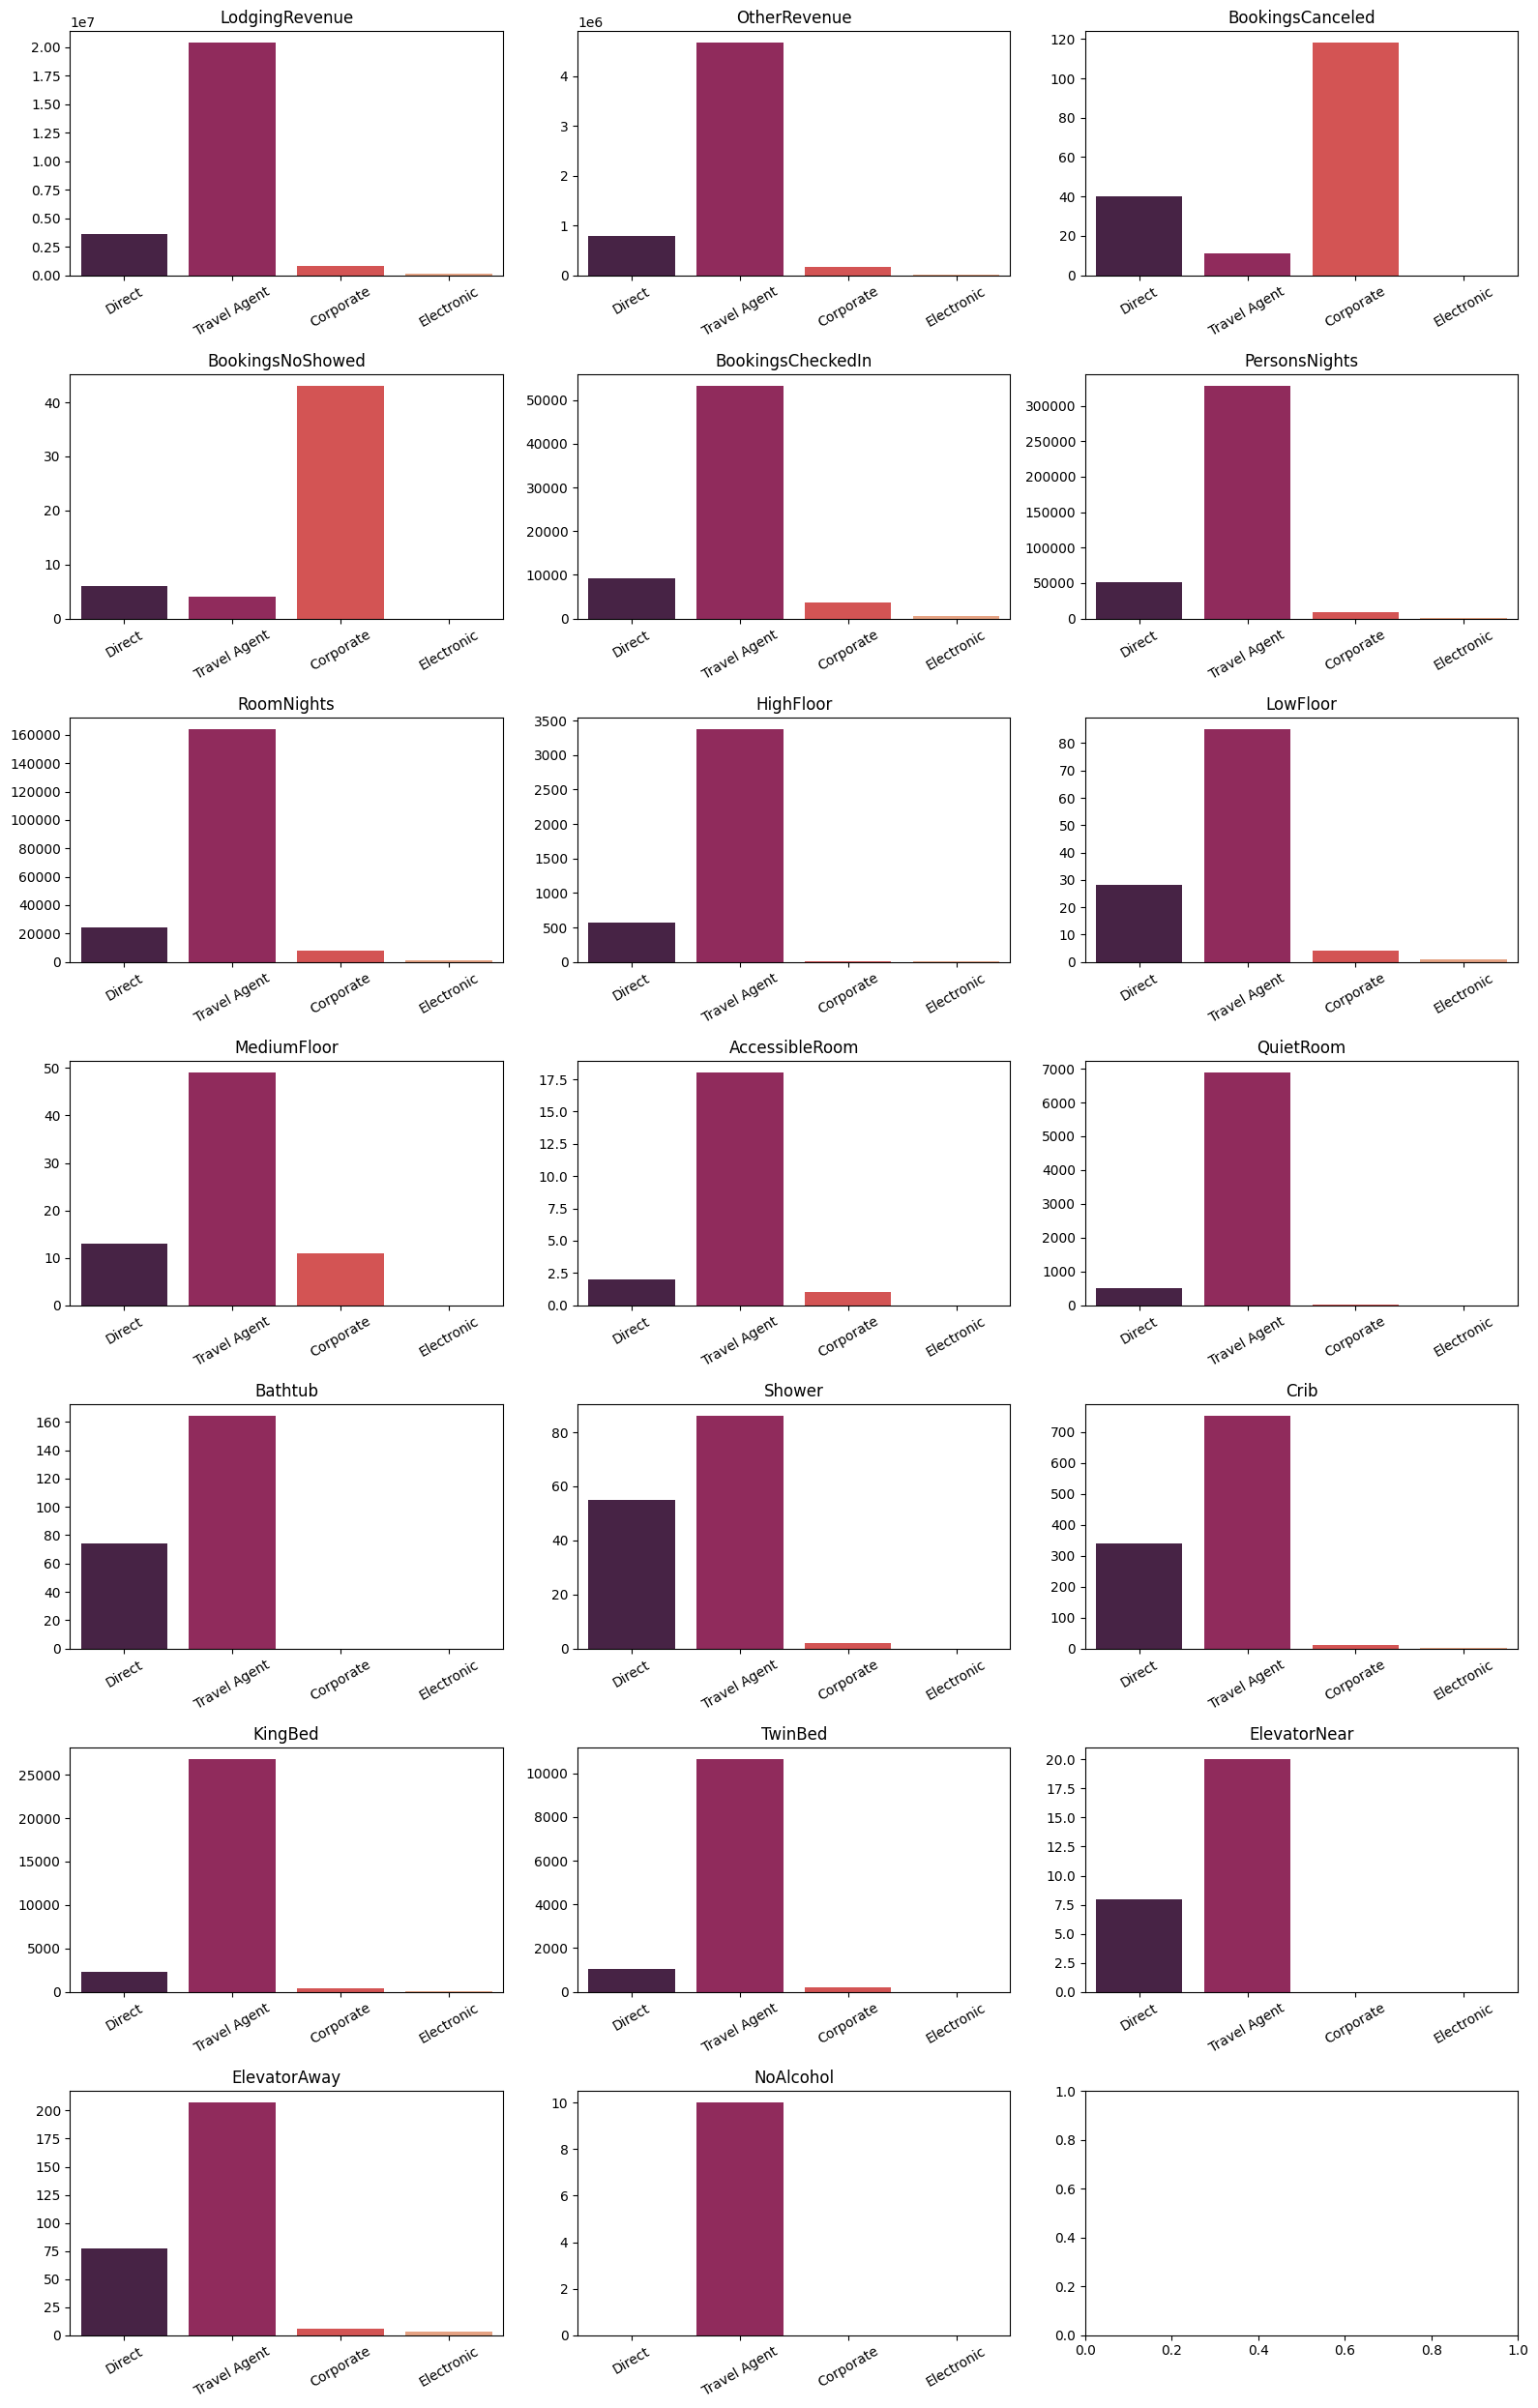

In [447]:
pd_dc_sum = dc_sum.toPandas()
pd_dc_sum.set_index("DistributionChannel", inplace=True)

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(7, 3, figsize=(16, 25))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Iterate over each column and plot
for i, x in enumerate(pd_dc_sum.columns):
    # Plot on the current subplot with default seaborn palette
    sns.barplot(x='DistributionChannel', y=pd_dc_sum[x], data=pd_dc_sum, hue=pd_dc_sum.index, ax=axes[i], dodge=False, legend=False, palette = 'rocket')
    
    # Rotate x-axis tick labels
    axes[i].tick_params(axis='x', rotation=30)
    
    # Add labels and title
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(x)

# plt.suptitle('Market Segment across other variables')
plt.tight_layout()
plt.show()


Inferences:-
- Revenue from 'Travel Agent' is higher than revenue from other sources
- 'Travel Agent' customers have the most check ins so incidently its bar is higher than all the other bars in all of the plots
- A similar trend from 'Market Segment Analysis' can be seen wherein customers of 'Corporate' origin have the most cancellations and tend to request the 'Medium Floors'

Transform string variables to dummies

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("StringIndexer and OneHotEncoder Example") \
    .getOrCreate()

cols_to_index = ['Nationality', 'DistributionChannel','MarketSegment'] # Define the columns to be indexed and encoded
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in cols_to_index]# Create a list of StringIndexer stages
pipeline = Pipeline(stages=indexers)# Define the pipeline with both indexing and encoding stages
pipeline_model = pipeline.fit(df)# Fit the pipeline to the data
df_transformed = pipeline_model.transform(df)# Transform the data using the pipeline
df_transformed.select('MarketSegment','MarketSegment_index').distinct().show(20)
df_transformed = df_transformed.drop(*cols_to_index)# Drop the original string columns
df_transformed.show()

Find the cluster number--Elbow Curve

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Assemble features
assemble = VectorAssembler(inputCols=df_transformed.columns, outputCol='features')
assembled_data = assemble.transform(df_transformed)

# Show the transformed DataFrame
assembled_data.show(5, truncate=False)

from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.select('standardized').show(2,truncate=False)

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

seed = 42

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i,seed=seed)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost,color='green')
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

optimal_k = df_cost.loc[df_cost.cost.idxmin(), 'cluster']
print("Optimal number of clusters:", optimal_k)

Customer Segmentation--K-Means Clustering Model

In [ ]:
KMeans_algo=KMeans(featuresCol='standardized', k=6)
KMeans_fit=KMeans_algo.fit(data_scale_output)
preds=KMeans_fit.transform(data_scale_output)

preds.show(15,0)

Analysis of Cluster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('Age','LodgingRevenue','OtherRevenue','BookingsNoShowed',
                      'BookingsCanceled','BookingsCheckedIn','PersonsNights',
                      'HighFloor','LowFloor','MediumFloor','ElevatorNear','ElevatorAway',
                      'QuietRoom','Nationality_index','MarketSegment_index',
                      'prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['Age','LodgingRevenue','OtherRevenue','BookingsNoShowed',
                      'BookingsCanceled','BookingsCheckedIn','PersonsNights',
                      'HighFloor','LowFloor','MediumFloor','ElevatorNear','ElevatorAway',
                      'QuietRoom','MarketSegment_index']

for i in list1:
    colors = sns.color_palette('husl', len(df_viz[str(i)].unique()))
    sns.barplot(x='prediction',y=str(i),data=avg_df, palette=colors)

    plt.show()